In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

In [3]:
df = pd.read_csv('dataset/movies_20k.csv', sep=',')
df

,index,text,label
0,0,I grew up (b. 1965) watching and loving the Th...,0
1,1,"When I put this movie in my DVD player, and sa...",0
2,2,Why do people who do not know what a particula...,0
3,3,Even though I have great interest in Biblical ...,0
4,5,A terrible movie as everyone has said. What ma...,0
...,...,...,...
19995,20042,"Again, I've read all of the comments posted he...",1
19996,20044,This is without a doubt the funniest of the Cu...,1
19997,20050,I first saw Thief as a child which makes me al...,1
19998,20051,This is a very fine and poetic story. Beautifu...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   20000 non-null  int64 
 1   text    20000 non-null  object
 2   label   20000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 468.9+ KB


#### 1. Data Pre-Processing: cleaning
text, remove stopwords,
stemming, lemmatization.**

Tahap ini melibatkan pra-pemrosesan data untuk membersihkan dan mengubah teks mentah menjadi bentuk yang dapat digunakan oleh SVM

In [5]:
## Data cleaning

text = df['text']
# 1 Lowering case: Mengubah teks menjadi huruf kecil untuk konsistensi dalam analisis
text = text.str.lower()
# text

In [6]:
# import re

# 2 Menghapus karakter khusus kecuali huruf dan angka
text = text.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
# text

In [7]:
# 3 Tokenisasi Memisahkan teks menjadi unit-unit yang lebih kecil seperti kata-kata atau frasa.
# nltk.download('punkt')
text = text.apply(lambda x: word_tokenize(x))
# text

In [8]:
# 4 Menghapus Stopwords Menghapus kata-kata umum yang tidak memberikan informasi penting dalam analisis.
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Menggunakan kamus stop words Bahasa Inggris
text = text.apply(lambda x: [word for word in x if word not in stop_words])
text

0        [grew, b, 1965, watching, loving, thunderbirds...
1        [put, movie, dvd, player, sat, coke, chips, ex...
2        [people, know, particular, time, past, like, f...
3        [even, though, great, interest, biblical, movi...
4        [terrible, movie, everyone, said, made, laugh,...
                               ...                        
19995    [ive, read, comments, posted, agree, many, int...
19996    [without, doubt, funniest, curly, stooges, sho...
19997    [first, saw, thief, child, makes, almost, old,...
19998    [fine, poetic, story, beautiful, scenery, magn...
19999    [sometimes, watch, movie, really, impressed, s...
Name: text, Length: 20000, dtype: object

In [9]:
# 5 Menghapus Kata Pendek: Menghapus kata-kata dengan panjang karakter yang terlalu pendek yang cenderung tidak memiliki makna.

min_length = 3  # Menentukan panjang minimum kata yang diizinkan
text = text.apply(lambda x: [word for word in x if len(word) >= min_length])
# text


In [10]:
# 6 Lematisasi atau Stemming: Mengubah kata-kata ke bentuk dasar mereka untuk mengurangi variasi kata yang sama
# Melakukan proses stemming (penggunaan kata dasar)
lemmatizer = WordNetLemmatizer()
 
# Membersihkan kalimat dari kata yang ada di stopwords
review = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [11]:
review

0        [grew, 1965, watching, loving, thunderbird, ma...
1        [put, movie, dvd, player, sat, coke, chip, exp...
2        [people, know, particular, time, past, like, f...
3        [even, though, great, interest, biblical, movi...
4        [terrible, movie, everyone, said, made, laugh,...
                               ...                        
19995    [ive, read, comment, posted, agree, many, inte...
19996    [without, doubt, funniest, curly, stooge, shor...
19997    [first, saw, thief, child, make, almost, old, ...
19998    [fine, poetic, story, beautiful, scenery, magn...
19999    [sometimes, watch, movie, really, impressed, s...
Name: text, Length: 20000, dtype: object

In [12]:
# 7 Menggabungkan Kembali Teks: Menggabungkan kembali unit-unit teks yang telah dibersihkan menjadi teks yang telah diolah sepenuhnya.
review = review.apply(lambda x: ' '.join(x))

In [14]:
preprocess = pd.concat([review, df['label']], axis=1)
# preprocess.to_csv('dataset/preprocess_movies_20k.csv',index=False)  
preprocess

,text,label
0,grew 1965 watching loving thunderbird mate sch...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,terrible movie everyone said made laugh cameo ...,0
...,...,...
19995,ive read comment posted agree many intelligent...,1
19996,without doubt funniest curly stooge short ive ...,1
19997,first saw thief child make almost old jinni gu...,1
19998,fine poetic story beautiful scenery magnificen...,1


#### 1.1 Load clean dataset

In [54]:
target_0 = preprocess[preprocess['label']==0].head(5000)
target_1 = preprocess[preprocess['label']==1].head(5000)
k_samples = pd.concat([target_0, target_1], axis=0)

#### 1.2 Wordcloud

In [55]:
def wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Tampilkan Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

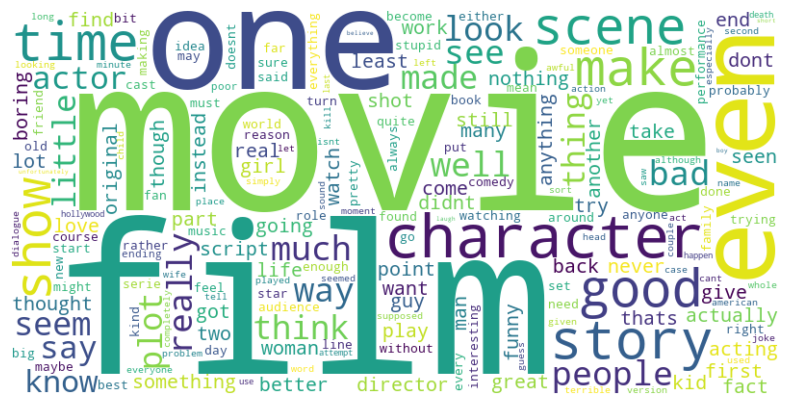

In [56]:
# Wordcloud Class 0: Negative
wordcloud(' '.join(target_0['text']))

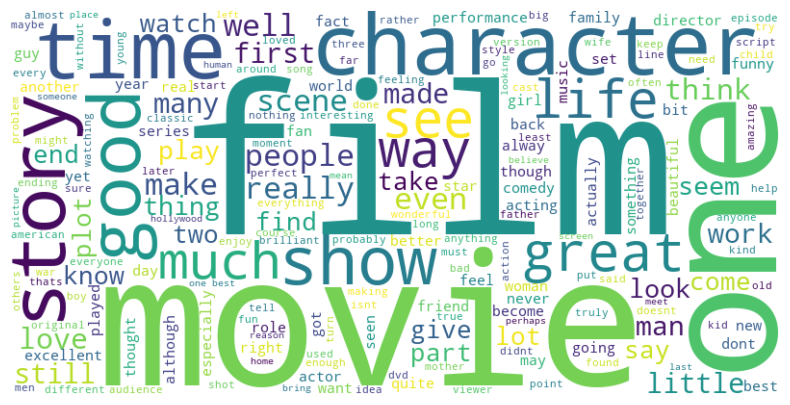

In [57]:
# Wordcloud Class 0: Negative
wordcloud(' '.join(target_1['text']))

#### 2. Feature Extraction: Bag-of-Word atau TF-IDF

Pada tahap ini, fitur-fitur atau representasi numerik diperoleh dari teks yang telah dipreproses

In [58]:
# #Bag-of-Word
# bow_cv = k_samples['text']
# # Inisialisasi CountVectorizer
# vectorizer = CountVectorizer()

# # Memproses teks dan membangun vocabulary
# bow_X = vectorizer.fit_transform(bow_cv)

# # Membuat DataFrame dari hasil Bag-of-Words
# df_bow = pd.DataFrame(bow_X.toarray(), columns=vectorizer.get_feature_names_out())

# df_bow.shape


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)

tfidf_text = k_samples['text']

# Memproses teks dan membangun TF-IDF
tfidf_X = vectorizer.fit_transform(tfidf_text)

# Membuat DataFrame dari hasil TF-IDF
df_tfidf = pd.DataFrame(tfidf_X.toarray(), columns=vectorizer.get_feature_names_out())

df_tfidf.shape

(10000, 1000)

#### 3. Pembagian Data

Data yang telah dipreproses dan direpresentasikan dalam bentuk fitur perlu dibagi menjadi set pelatihan (training set) dan set pengujian (test set). Set pelatihan digunakan untuk melatih model SVM, sedangkan set pengujian digunakan untuk menguji kinerja model

In [60]:
X = df_tfidf
y = k_samples['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 4. Pelatihan Model

Model SVM dilatih menggunakan set pelatihan yang telah dibagi sebelumnya. SVM mempelajari pola dalam data pelatihan untuk memisahkan kelas positif dan negatif. Pada tahap ini, SVM menemukan hyperplane terbaik yang memaksimalkan margin antara kelas-kelas tersebut.

In [61]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [62]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [63]:
rfc_pred = rfc.predict(X_test)

In [64]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42, n_jobs=6)

In [65]:
lr.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=500, n_jobs=6, random_state=42)

In [66]:
lr_pred = lr.predict(X_test)

#### 5. Evaluasi Model

Setelah model dilatih, langkah selanjutnya adalah menguji kinerjanya pada set pengujian yang telah dipisahkan sebelumnya. Beberapa metrik evaluasi yang umum digunakan dalam analisis sentimen adalah akurasi, presisi, recall, dan F1-score. Metrik ini membantu mengukur sejauh mana model dapat mengklasifikasikan sentimen dengan benar.

In [67]:
def evaluation(y_test, pred):
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print("Precsion:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))

In [68]:
evaluation(y_test, rfc_pred)

Precsion: 0.8271983640081799
Recall: 0.8188259109311741
F1 Score: 0.8229908443540183
[[843 169]
 [179 809]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1012
           1       0.83      0.82      0.82       988

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [69]:
evaluation(y_test, lr_pred)

Precsion: 0.8317120622568094
Recall: 0.8653846153846154
F1 Score: 0.8482142857142857
[[839 173]
 [133 855]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1012
           1       0.83      0.87      0.85       988

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



**6. Prediksi**

Setelah model dievaluasi dengan baik, model tersebut dapat digunakan untuk memprediksi sentimen pada data teks baru. Teks baru akan mengalami pra-pemrosesan yang sama seperti pada tahap 1 dan diubah menjadi fitur-fitur menggunakan metode yang sama seperti pada tahap 2. Kemudian, model SVM digunakan untuk mengklasifikasikan sentimen berdasarkan fitur-fitur tersebut

In [1]:
# Make predictions on new text data
input_text = ['this movie is so sad']
new_text_bow = vectorizer.transform(input_text)
y_pred = lr.predict(new_text_bow)

print("Predicted Sentiment:", y_pred[0])

NameError: name 'vectorizer' is not defined